In [17]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.optimize
import matplotlib.dates as mdates
from datetime import datetime, timedelta
pd.set_option('display.max_rows', 500)

In [18]:
confirmed_df = pd.read_csv(r'../csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
confirmed_df.rename(columns={'Province/State': 'Province_State', 'Country/Region': 'Country_Region'}, inplace=True)
confirmed_df.head()

,Province_State,Country_Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20
0,NaN,Thailand,15.0000,101.0000,2,3,5,7,8,8,...,82,114,147,177,212,272,322,411,599,599.0
1,NaN,Japan,36.0000,138.0000,2,1,2,2,4,4,...,773,839,825,878,889,924,963,1007,1086,1086.0
2,NaN,Singapore,1.2833,103.8333,0,1,3,3,4,5,...,212,226,243,266,313,345,385,432,455,455.0
3,NaN,Nepal,28.1667,84.2500,0,0,0,1,1,1,...,1,1,1,1,1,1,1,1,2,2.0
4,NaN,Malaysia,2.5000,112.5000,0,0,0,3,4,4,...,238,428,566,673,790,900,1030,1183,1306,1306.0


In [19]:
def create_df(a_series):
    dates = a_series.index[4:].values
    counts = a_series.values[4:]
    df = pd.DataFrame({'date': dates, 'count': counts})
    df['Province_State'] = a_series['Province_State'] 
    df['Country_Region'] = a_series['Country_Region'] 
    df['Lat'] = a_series['Lat'] 
    df['Long'] = a_series['Long'] 
    return df

In [20]:
confirmed_df_2 = pd.concat(confirmed_df.apply(create_df, axis=1).values).set_index(['Country_Region', 'Province_State', 'Lat', 'Long'])
confirmed_df_2['date'] = pd.to_datetime(confirmed_df_2['date'])
confirmed_df_2.head()

date count
Country_Region Province_State Lat  Long                  
Thailand       NaN            15.0 101.0 2020-01-22     2
                                   101.0 2020-01-23     3
                                   101.0 2020-01-24     5
                                   101.0 2020-01-25     7
                                   101.0 2020-01-26     8

In [21]:
a = confirmed_df_2.reset_index()
b = a.groupby(['Country_Region', 'date']).agg({'Lat': 'mean', 'Long': 'mean', 'count': 'sum'})
countries_df = b.reset_index().set_index(['Country_Region', 'Lat', 'Long'])
countries_df.tail()

date  count
Country_Region Lat   Long                  
Zimbabwe       -20.0 30.0 2020-03-19    0.0
                     30.0 2020-03-20    1.0
                     30.0 2020-03-21    3.0
                     30.0 2020-03-22    3.0
                     30.0 2020-03-23    3.0

In [22]:
# country_df = confirmed_df_2.query('Country_Region == "Israel"')
country_df = countries_df.query('Country_Region == "US"')
# country_df = confirmed_df_2.query('Country_Region == "Spain"')
# country_df = confirmed_df_2.query('Country_Region == "Italy"')
country_df.tail()

date    count
Country_Region Lat       Long                          
US             38.499716 -92.821004 2020-03-19  13677.0
                         -92.821004 2020-03-20  19100.0
                         -92.821004 2020-03-21  25489.0
                         -92.821004 2020-03-22  33272.0
                         -92.821004 2020-03-23  33276.0

In [23]:
last_date = country_df['date'].iloc[-1]
last_date

Timestamp('2020-03-23 00:00:00')

In [24]:
values = list(country_df.index[0]) + [last_date + timedelta(days=1), 945]
columns = list(country_df.index.names) + country_df.columns.tolist()
values, columns
row_df = pd.DataFrame([values], columns=columns).set_index(country_df.index.names)
row_df

,,,date,count
Country_Region,Lat,Long,,
US,38.499716,-92.821004,2020-03-24,945


In [25]:
# country_updated_df = country_df.append(row_df)
# country_updated_df.tail()
country_updated_df = country_df

<IPython.core.display.Javascript object>


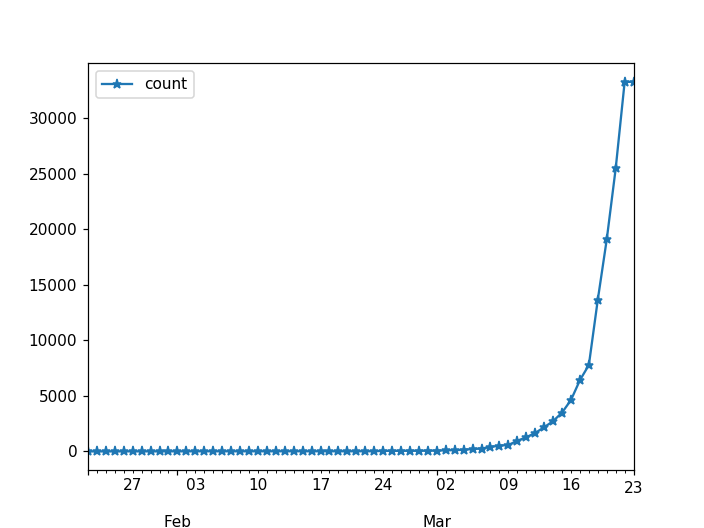

In [26]:
%matplotlib notebook
country_updated_df.plot(x='date', y='count', marker='*')

In [27]:
def exponential(x, a, k, b):
    return a*np.exp(x*k) + b

In [28]:
non_zero_country_df = country_updated_df[country_updated_df['count'] > 0]
y_array_exp = non_zero_country_df['count'].values
ref_date = datetime(2020, 1, 1)
x_array = (non_zero_country_df['date'] - ref_date).dt.days.values.astype(float)

In [29]:
last_model_date = country_updated_df['date'].iloc[-1]
# last_model_date = datetime(2020, 3, 18)
last_model_index = np.argmin((non_zero_country_df['date'] - last_model_date).abs().values)
last_model_index

61

In [30]:
popt_exponential, pcov_exponential = scipy.optimize.curve_fit(exponential, x_array[:last_model_index], y_array_exp[:last_model_index], p0=
(0.0021819439144763727, 0.2196989290489097, -0.8576298838011189))
a, k, b = popt_exponential
a, k, b, np.exp(k), np.exp(k*7)

(1.9658005986916304e-07,
 0.3194659141606338,
 22.600854791349995,
 1.3763924562743175,
 9.358278935072338)

In [31]:
estimated = exponential(x_array, a, k, b)
non_zero_country_df['estimated'] = estimated
estimated

array([2.26010159e+01, 2.26010765e+01, 2.26011600e+01, 2.26012749e+01,
       2.26014330e+01, 2.26016507e+01, 2.26019502e+01, 2.26023625e+01,
       2.26029300e+01, 2.26037111e+01, 2.26047862e+01, 2.26062660e+01,
       2.26083027e+01, 2.26111060e+01, 2.26149645e+01, 2.26202753e+01,
       2.26275851e+01, 2.26376462e+01, 2.26514942e+01, 2.26705545e+01,
       2.26967889e+01, 2.27328978e+01, 2.27825978e+01, 2.28510045e+01,
       2.29451589e+01, 2.30747524e+01, 2.32531239e+01, 2.34986330e+01,
       2.38365500e+01, 2.43016564e+01, 2.49418252e+01, 2.58229489e+01,
       2.70357207e+01, 2.87049708e+01, 3.10025141e+01, 3.41648352e+01,
       3.85174303e+01, 4.45083092e+01, 5.27541098e+01, 6.41035675e+01,
       7.97248754e+01, 1.01225926e+02, 1.30819809e+02, 1.71552608e+02,
       2.27616924e+02, 3.04783426e+02, 4.10994816e+02, 5.57183374e+02,
       7.58396201e+02, 1.03534402e+03, 1.41653291e+03, 1.94119841e+03,
       2.66334406e+03, 3.65729988e+03, 5.02537318e+03, 6.90837894e+03,
      

<IPython.core.display.Javascript object>


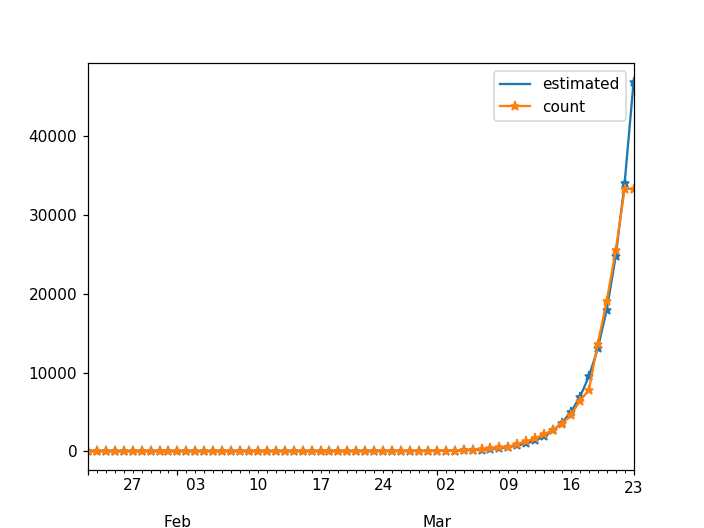

In [32]:
plt.figure()
ax = plt.gca()
non_zero_country_df.plot(ax=ax, x='date', y='estimated' ,marker='*')
non_zero_country_df.plot(ax=ax, x='date', y='count' ,marker='*')
plt.show()

In [33]:
non_zero_country_df

date    count     estimated
Country_Region Lat       Long                                        
US             38.499716 -92.821004 2020-01-22      1.0     22.601016
                         -92.821004 2020-01-23      1.0     22.601077
                         -92.821004 2020-01-24      2.0     22.601160
                         -92.821004 2020-01-25      2.0     22.601275
                         -92.821004 2020-01-26      5.0     22.601433
                         -92.821004 2020-01-27      5.0     22.601651
                         -92.821004 2020-01-28      5.0     22.601950
                         -92.821004 2020-01-29      5.0     22.602363
                         -92.821004 2020-01-30      5.0     22.602930
                         -92.821004 2020-01-31      7.0     22.603711
                         -92.821004 2020-02-01      8.0     22.604786
                         -92.821004 2020-02-02      8.0     22.606266
                         -92.821004 2020-02-03     11.0     22.608303
                         -92.821004 2020-02-04     11.0     22.611106
                         -92.821004 2020-02-05     11.0     22.614965
                         -92.821004 2020-02-06     11.0     22.620275
                         -92.821004 2020-02-07     11.0     22.627585
                         -92.821004 2020-02-08     11.0     22.637646
                         -92.821004 2020-02-09     11.0     22.651494
                         -92.821004 2020-02-10     11.0     22.670554
                         -92.821004 2020-02-11     12.0     22.696789
                         -92.821004 2020-02-12     12.0     22.732898
                         -92.821004 2020-02-13     13.0     22.782598
                         -92.821004 2020-02-14     13.0     22.851004
                         -92.821004 2020-02-15     13.0     22.945159
                         -92.821004 2020-02-16     13.0     23.074752
                         -92.821004 2020-02-17     13.0     23.253124
                         -92.821004 2020-02-18     13.0     23.498633
                         -92.821004 2020-02-19     13.0     23.836550
                         -92.821004 2020-02-20     13.0     24.301656
                         -92.821004 2020-02-21     15.0     24.941825
                         -92.821004 2020-02-22     15.0     25.822949
                         -92.821004 2020-02-23     15.0     27.035721
                         -92.821004 2020-02-24     51.0     28.704971
                         -92.821004 2020-02-25     51.0     31.002514
                         -92.821004 2020-02-26     57.0     34.164835
                         -92.821004 2020-02-27     58.0     38.517430
                         -92.821004 2020-02-28     60.0     44.508309
                         -92.821004 2020-02-29     68.0     52.754110
                         -92.821004 2020-03-01     74.0     64.103567
                         -92.821004 2020-03-02     98.0     79.724875
                         -92.821004 2020-03-03    118.0    101.225926
                         -92.821004 2020-03-04    149.0    130.819809
                         -92.821004 2020-03-05    217.0    171.552608
                         -92.821004 2020-03-06    262.0    227.616924
                         -92.821004 2020-03-07    402.0    304.783426
                         -92.821004 2020-03-08    518.0    410.994816
                         -92.821004 2020-03-09    583.0    557.183374
                         -92.821004 2020-03-10    959.0    758.396201
                         -92.821004 2020-03-11   1281.0   1035.344019
                         -92.821004 2020-03-12   1663.0   1416.532906
                         -92.821004 2020-03-13   2179.0   1941.198414
                         -92.821004 2020-03-14   2727.0   2663.344062
                         -92.821004 2020-03-15   3499.0   3657.299884
                         -92.821004 2020-03-16   4632.0   5025.373180
                         -92.821004 2020-03-17   642

In [34]:
extrapolation_dates_series = pd.Series([last_model_date + timedelta(days=k) for k in range(1, 7)])
extrapolation_x_array = (extrapolation_dates_series - ref_date).dt.days.values.astype(float)
extrapolation_estimated = exponential(extrapolation_x_array, a, k, b)
extrapolation_df = pd.DataFrame({'date': extrapolation_dates_series, 'estimated': extrapolation_estimated})
extrapolation_df

,date,estimated
0,2020-03-24,64461.632895
1,2020-03-25,88715.998445
2,2020-03-26,122099.524219
3,2020-03-27,168048.357258
4,2020-03-28,231291.984428
5,2020-03-29,318340.035773


<IPython.core.display.Javascript object>


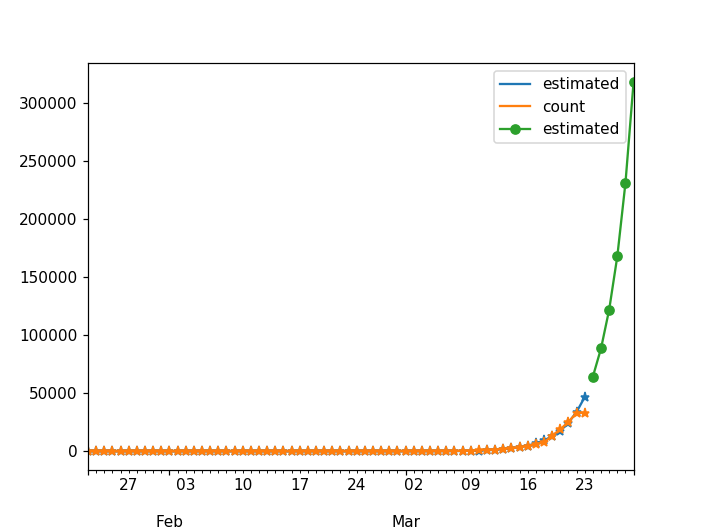

In [35]:
plt.figure()
ax = plt.gca()
non_zero_country_df.plot(ax=ax, x='date', y='estimated' ,marker='*')
non_zero_country_df.plot(ax=ax, x='date', y='count' ,marker='*')
extrapolation_df.plot(ax=ax, x='date', y='estimated' ,marker='o')
plt.show()

In [36]:
# %matplotlib notebook
# plt.figure(figsize=(9, 8))
# for iteration in range(0, 8):
#     plt.subplot(331 + iteration)
#     n_days = int(iteration * 7)
#     x_long_term = range(len(y_array_exp) + n_days)
#     y_forecast = exponential(x_long_term, a, k, b)
#     max_val = y_forecast.max() 
#     plt.plot(estimated)
#     plt.plot(y_array_exp, '--*')
#     plt.plot(y_forecast, '--b')
#     plt.title(f'weeks from now: {iteration}\ncases:{int(max_val):,}', y=.5)

# countries growth per week

In [37]:
def get_growth_rate(df):
    try:
        non_zero_country_df = df[df['count'] > 0]
        y_array_exp = non_zero_country_df['count'].values
        ref_date = datetime(2020, 1, 1)
        x_array = (non_zero_country_df['date'] - ref_date).dt.days.values.astype(float)
        popt_exponential, pcov_exponential = scipy.optimize.curve_fit(exponential, x_array[:last_model_index], y_array_exp[:last_model_index], p0=
        (0.0021819439144763727, 0.2196989290489097, -0.8576298838011189))
        a, k, b = popt_exponential
        estimated = exponential(x_array, a, k, b)
        max_error_in_percentage = np.abs(estimated - y_array_exp).max() / y_array_exp.max() * 100
        return_values = [np.exp(k), np.exp(k*7), max_error_in_percentage, y_array_exp.max()]        
    except:
        return_values = [None, None, None, None]
    names = ['day_rate', 'week_rate', 'max_error_in_percentage', 'confirmed_cases']
    return pd.Series(return_values, index=names)

In [38]:
countries_stat_df = countries_df.groupby('Country_Region').apply(get_growth_rate)
countries_stat_df

/home/erez/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


,day_rate,week_rate,max_error_in_percentage,confirmed_cases
Country_Region,,,,
Afghanistan,1.140200,2.505342,1.682752e+01,40.0
Albania,NaN,NaN,NaN,NaN
Algeria,1.238069,4.458756,1.456467e+01,201.0
Andorra,1.259570,5.029868,1.735575e+01,113.0
Angola,NaN,NaN,NaN,NaN
Antigua and Barbuda,1.245698,4.654686,1.753514e-07,1.0
Argentina,1.227412,4.196948,1.275112e+01,225.0
Armenia,1.198935,3.560973,1.356521e+01,194.0
Australia,1.213820,3.882228,1.010109e+01,1314.0


In [39]:
countries_stat_sorted_df = countries_stat_df.dropna().round(4).sort_values(by='confirmed_cases', ascending=False)
countries_stat_sorted_df

,day_rate,week_rate,max_error_in_percentage,confirmed_cases
Country_Region,,,,
Italy,1.1378,2.4686,11.7607,59138.0
US,1.3764,9.3583,40.7619,33276.0
Spain,1.1914,3.4073,13.8599,28768.0
Germany,1.1992,3.5661,15.7587,24873.0
Iran,1.0599,1.5031,10.7388,21638.0
France,1.1669,2.9468,14.5104,16176.0
"Korea, South",1.0399,1.3155,27.4554,8897.0
Switzerland,1.1850,3.2803,12.7144,7245.0
United Kingdom,1.2128,3.8591,13.1744,5741.0


In [ ]:
# countries_stat_sorted_df.to_excel('countries_stat.xlsx')